[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hVWjA8FuakbhzQ6VVFCr42xtz4fxLV-z?usp=sharing)

# Cellular communication channels

In [1]:
import numpy as np
import panel as pn
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from scipy.special import factorial
set_matplotlib_formats('svg')
pn.extension()

Concepts from information theory have been used to study cellular information channels in cell signaling and development.

Let’s study the properties of a cellular information channel and consider optimal encoding strategies. Imagine a signal secreted by one cell and received by a second. The sending cell secretes an integer number of molecules ranging from 1 to 5. For the sending cell, $P(y) = \frac{1}{5}$ for all $y \in \{1,2,3,4,5\}$ . The receiving cell receives molecules through a set of receptors that are the subject to strong stochastic counting effects.

Given $y$ secreted molecules, the receiving cell senses these molecules through a receptor that displays Poisson counting statistics. For this class of problems, in general, we should consider Binomial counting statistics. Poisson counting provides a simple limiting case that we use here for simplicity.
The probability that the receiving cell registers $z$ molecules given $y$ input molecules is:

$$P(z \mid y) = \frac{(p_{c}y)^z e^{(-p_{c}y)}}{z!}$$

where $p_c$ is the receptor counting efficiency. 

Let's construct an expression for $P(z,y)$:
$$P(z, y) = P(y)P(z \mid y)$$
$$P(z, y) = \frac{1}{5}\frac{(p_{c}y)^z e^{(-p_{c}y)}}{z!}$$
and $P(z)$:
$$P(z) = \sum_{y}P(z,y)$$
$$P(z) = \sum_{y}P(y)P(z \mid y)$$
$$P(z) = \sum_{y}\frac{1}{5}\frac{(p_{c}y)^z e^{(-p_{c}y)}}{z!}$$


We will transform these mathematical expressions into code. So we can compute the mutual information between z and y later.

In [2]:
# Let's code a poisson distribution function:
def poisson(lambda_, k):
  return ((lambda_**k)*(np.exp(-lambda_)))/factorial(k)

Column
    [0] Column
        [0] FloatSlider(end=5, name='lambda', start=0.1, step=0.01, value=3)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00102')
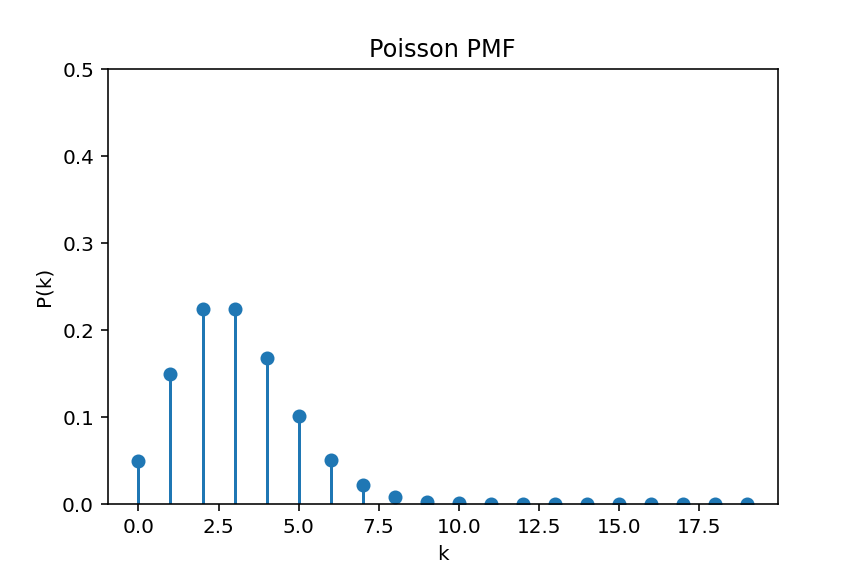

In [3]:
# Let's see poisson dist. as we change λ:
def display(lambda_ = 3,):
  k = np.arange(0,20)
  p = poisson(lambda_, k)
  fig = plt.figure()
  plt.stem(k, p, basefmt=" ", use_line_collection = True)
  plt.ylim(0,.5)
  plt.ylabel('P(k)')
  plt.xlabel('k')
  plt.title('Poisson PMF')
  plt.close()
  return fig

slider_lambda = pn.widgets.FloatSlider(name='lambda', start=0.1, end=5, step=0.01, value=3)
pn.interact(display, lambda_ = slider_lambda)

In [4]:
# Now, we can use our poisson function to construct the likelihood: p(z|y).
# The probability of the receiving cell sensing z molecules given y secreted molecules.
def P_z_given_y(y, z, pc):
  lambda_ = pc*y
  return poisson(lambda_, z)

Column
    [0] Column
        [0] IntSlider(end=5, name='y', start=1, value=2)
        [1] FloatSlider(name='pc', value=0.5)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00111')
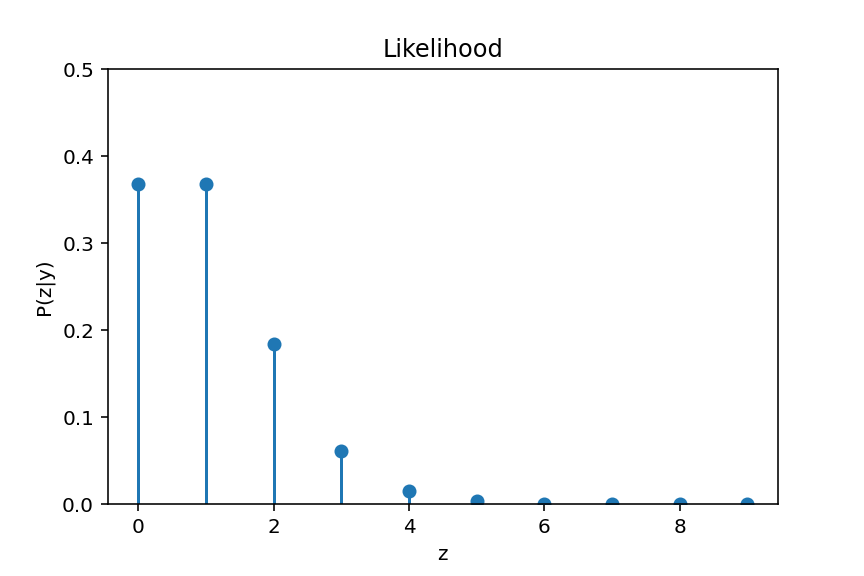

In [5]:
# The likelihood depends on "y" secreted molecules and the efficiency of the receptor "pc":
def display(y = 2, pc = .5):
  z = np.arange(0,10)
  p = P_z_given_y(y, z, pc)
  fig = plt.figure()
  plt.stem(z, p, basefmt=" ", use_line_collection = True)
  plt.ylim(0,.5)
  plt.ylabel('P(z|y)')
  plt.xlabel('z')
  plt.title('Likelihood')
  plt.close()
  return fig
pn.interact(display, y = (1,5),  pc = (0,1))

In [6]:
# For the sending cell the probability of secreting "y" molecules is uniform:
# defined only for y in {1,2,3,4,5}
def P_y(y):
  p = 0
  if y >= 1 and y <= 5:
    p = 1/5
  return p

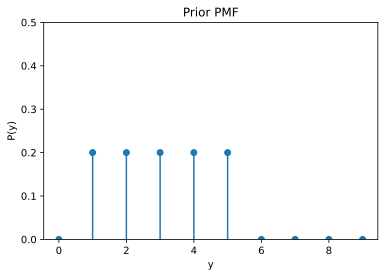

In [7]:
y = np.arange(0,10)
p = list(map(P_y, y))
plt.stem(y, p, basefmt=" ", use_line_collection = True)
plt.ylim(0,.5)
plt.ylabel('P(y)')
plt.xlabel('y')
plt.title('Prior PMF');

In [8]:
# The joint distribution is just the product of the likelihood and the prior:
# p(y,z) = P(z|y)p(y)
def P_zy(y, z, pc = .5):
  return P_z_given_y(y, z, pc) * P_y(y)

In [9]:
# We can use marginalization for getting the "evidence" p(z).
def P_z(z, pc = 0.5):
  p = 0
  for y_i in range(1,6):
    p += P_zy(y_i, z, pc)
  return p

Column
    [0] Column
        [0] FloatSlider(name='pc', value=0.5)
    [1] Row
        [0] Matplotlib(Figure, name='interactive00121')
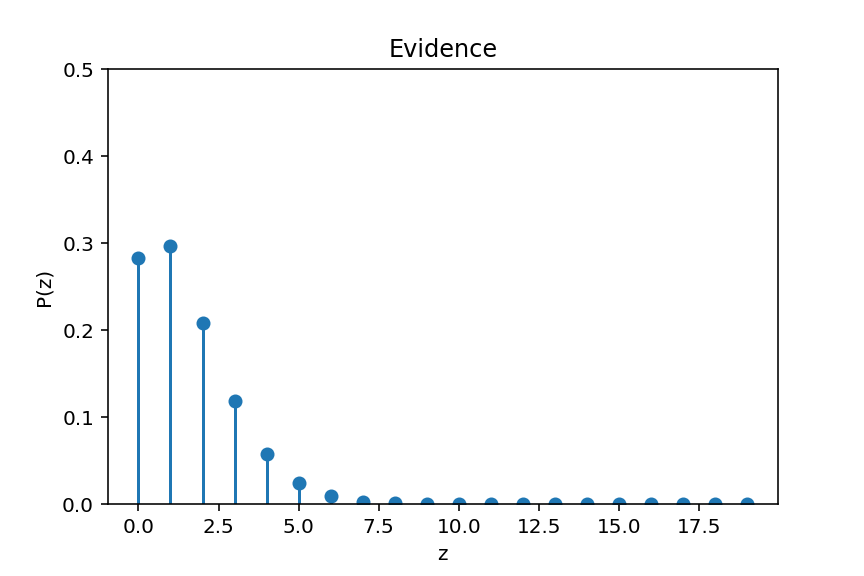

In [10]:
def display(pc = .5):
  z = np.arange(0,20)
  p = P_z(z, pc)
  fig = plt.figure()
  plt.stem(z, p, basefmt=" ", use_line_collection = True)
  plt.ylim(0,.5)
  plt.ylabel('P(z)')
  plt.xlabel('z')
  plt.title('Evidence');
  plt.close()
  return fig
pn.interact(display, pc = (0,1))

We can use python to calculate the mutual information, $I[Z, Y]$, between $Z$ and $Y$ , between signal sent by a sending cell and received by a receiving cell.

$$\begin{eqnarray}
I[Z,Y] &=& D_{KL}\left(P(z,y) \middle\| P(z)P(y) \right)\\
 &=& \mathbb{E}_{P(z,y)}\log\frac{P(z,y)}{P(z)P(y)}\\
 &=& \sum_z \sum_y P(z,y)\log\frac{P(z,y)}{P(z)P(y)}\\
\end{eqnarray}$$


In [11]:
def mutual_info(P_zy, P_y, P_z, pc = 0.5):
  mi = 0
  for z_i in range(1, 6):
    for y_i in range(1,6):
      mi += P_zy(y_i, z_i, pc) * np.log2( 
          P_zy(y_i, z_i, pc) / (P_y(y_i) * P_z(z_i, pc))
          ) 

  return mi

In [12]:
mutual_info(P_zy, P_y, P_z, pc = .5)

0.12342236640627208

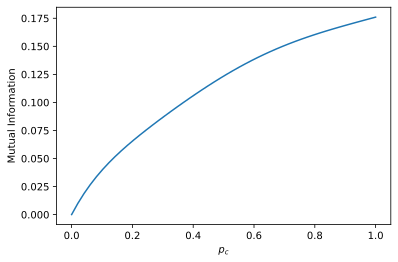

In [13]:
# we can plot the mutual information between z and y as a function of pc.
pc = np.linspace(0.0001,1)
mi = mutual_info(P_zy, P_y, P_z, pc)
plt.plot(pc, mi)
plt.xlabel('$p_c$')
plt.ylabel('Mutual Information');

Imagine we can modify the distribution of signals used by the sending cell to transmit information. How can we modify the input distribution to increase the mutual information and hence the capacity of this cellular information channel so that the sending cell still only sends 5 different levels of the signal, but, in the redesigned scheme, the signals can be more easily decoded by a receiving cell? 

If we set high probability for three levels of signal: low = 1, medium = 3, and high = 5. And set low probability for the remaining states (2 and 4). We can achieve less error in decoding. Most errors in decoding occur between adjacent levels of signal, for example (2 and 3).

In [14]:
def P_y_new(y):
  p_dir = {
      1:3/10,
      2:.5/10,
      3:3/10,
      4:.5/10,
      5:3/10,
      }
  p = 0
  if y >= 1 and y <= 5:
     p = p_dir[y]
  return p

def P_zy_new(y, z, pc = .5):
  return P_z_given_y(y, z, pc) * P_y_new(y)

def P_z_new(z, pc = 0.5):
  p = 0
  for y_i in range(1,6):
    p += P_zy_new(y_i, z, pc)
  return p

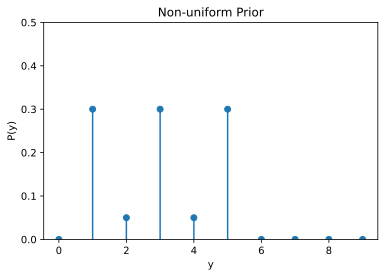

In [15]:
y = np.arange(0,10)
p = list(map(P_y_new, y))
plt.stem(y, p, basefmt=" ", use_line_collection = True)
plt.ylim(0,.5)
plt.ylabel('P(y)')
plt.xlabel('y')
plt.title('Non-uniform Prior');

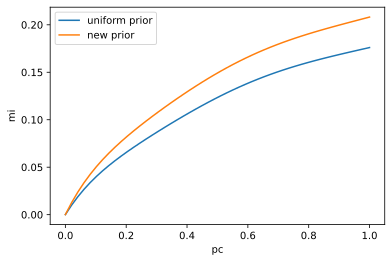

In [16]:
pc = np.linspace(0.0001,1)
mi_0 = mutual_info(P_zy, P_y, P_z, pc)
mi_1 = mutual_info(P_zy_new, P_y_new, P_z_new, pc)

plt.plot(pc, mi_0, label = 'uniform prior')
plt.plot(pc, mi_1, label = 'new prior')
plt.xlabel('pc')
plt.ylabel('mi');
plt.legend();